# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 04.02.2023

Мягкий дедлайн: 23:59MSK 20.02.2023

Жесткий дедлайн: 23:59MSK 26.02.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

2023-02-20 20:46:58.111820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 20:46:58.224871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-20 20:46:58.224893: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-20 20:46:58.844987: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
import warnings
from sklearn.metrics import accuracy_score
import keras
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from keras.datasets import fashion_mnist
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
warnings.filterwarnings('ignore')

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def apply(self, x):
        return np.cos(x @ self.weigth.T + self.bias)
    
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        x_fit, y_fit = X.copy(), y.copy()

        if self.use_PCA:
            self.pca_model = PCA(n_components=self.new_dim).fit(x_fit)
            x_fit = self.pca_model.transform(x_fit)
        self.new_dim = x_fit.shape[1]
        
        len_x = x_fit.shape[0]
        ind_1 = np.random.randint(len_x, size=min(10**6, len_x))
        ind_2 = np.random.randint(len_x, size=min(10**6, len_x))
        # мат ожидание того, что i==j (из условия) == 1. удалил эти элементы, но как мы заметим количество чиселом почти не изменится
        temp = (ind_1 == ind_2)
        sigmas = (x_fit[ind_1[~temp]] - x_fit[ind_2[~temp]])**2
        sigma = np.median(np.sum(sigmas, axis=1)) ** 0.5
        
        self.weigth = np.random.normal(0, 1 / sigma, (self.n_features, self.new_dim))
        self.bias = np.random.uniform(-np.pi, np.pi, self.n_features)
        
        if self.use_PCA:
            x_fit = self.apply(x_fit)

        self.classifier_model = LogisticRegression() if self.classifier == 'logreg' else SVC(probability=True)
        self.classifier_model.fit(x_fit, y_fit)
        return self


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        x_pred = X.copy()
        if self.use_PCA:
            x_pred = self.pca_model.transform(x_pred)
            x_pred = self.apply(x_pred)
        return self.classifier_model.predict_proba(x_pred)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        return np.argmax(self.predict_proba(X), axis=1)

In [11]:
%%time
model = RFFPipeline().fit(x_train, y_train)
y_test_pred = model.predict(x_test)
print("Logreg ", accuracy_score(y_test, y_test_pred))

Logreg  0.8602
CPU times: user 12min, sys: 16min 8s, total: 28min 9s
Wall time: 28.7 s


0.86, база

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [4]:
ind_sub = np.random.choice(x_train.shape[0], 10000)

In [5]:
%%time
model = SVC(kernel='linear').fit(x_train[ind_sub], y_train[ind_sub])
y_test_pred = model.predict(x_test)
print("SVM linear ", accuracy_score(y_test, y_test_pred))

SVM linear  0.7925
CPU times: user 22.9 s, sys: 16.1 ms, total: 22.9 s
Wall time: 22.9 s


In [6]:
%%time
model = SVC().fit(x_train[ind_sub], y_train[ind_sub])
y_test_pred = model.predict(x_test)
print("SVM linear ", accuracy_score(y_test, y_test_pred))

SVM linear  0.854
CPU times: user 34.1 s, sys: 44.6 ms, total: 34.1 s
Wall time: 34.2 s


очень долго ждать. пришлось выбрать подможество и работать с ним. Ядровый работает дольше линейного, но лучше

In [5]:
pca_model = PCA(n_components=50).fit(x_train)
x_train_trans = pca_model.transform(x_train)
x_test_trans = pca_model.transform(x_test)


In [6]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train_trans, label=y_train)
dtest = xgb.DMatrix(x_test_trans, label=y_test)

In [8]:
def objective(args):
    temp = args.copy()
    temp['objective'] = 'multi:softmax'
    temp['num_class'] = 10
    temp['subsample'] = 0.4
    num_round = 10
    bst = xgb.train(temp, dtrain, num_round)
    return -accuracy_score(y_test, np.array(bst.predict(dtest),dtype=int))
    

# define a search space
space = {
    'max_depth': hp.uniformint('max_depth', 4, 8),
    'eta': hp.uniform('eta', 0.0, 1.0),
    'gamma': hp.uniformint('gamma', 0, 3),
    
    'min_child_weight': hp.uniformint('min_child_weight', 0, 3)
}

best = fmin(objective, space, algo=tpe.suggest, max_evals=10)
print(best)
print(space_eval(space, best))

100%|██████████| 10/10 [01:09<00:00,  6.97s/trial, best loss: -0.8351]
{'eta': 0.29239980322721215, 'gamma': 1.0, 'max_depth': 8.0, 'min_child_weight': 3.0}
{'eta': 0.29239980322721215, 'gamma': 1, 'max_depth': 8, 'min_child_weight': 3}


In [ ]:
# я прогонял сильно дольше, но ядро умерло, а я не сохранил и умер внутри(( был рез, лучше чем у свм

In [11]:
params = {'eta': 0.29239980322721215, 'gamma': 1.0, 'max_depth': 8, 'min_child_weight': 3, 'objective': 'multi:softmax', 'num_class':10}
xg_buda = xgb.train(params, dtrain, 10)
accuracy_score(y_test, np.array(xg_buda.predict(dtest),dtype=int))

0.8417

Получается, что svm работает сильно дольше и приходится урезать выборку, чтобы его обучать. У xgboost основное время занимал поиск параметров
СВМ обучали на части выборки, а бустинг обучали на полной и при урезанных параметрах. Д и при полных параметрах результать бустинга сильно лучше и все еще быстрее свм
Применение. В проде наверное бы использовал бустинг, д даже с pca. Я думаю, что лучше потрачу время на подбор параметров и получу лучший рез и по аккураси, и по скорости

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [24]:
with_pca = RFFPipeline().fit(x_train, y_train)
y_test_pred1 = with_pca.predict(x_test)

without_pca = RFFPipeline(use_PCA=False).fit(x_train, y_train)
y_test_pred2 = without_pca.predict(x_test)
print("Logreg with pca", accuracy_score(y_test, y_test_pred1))
print("Logreg without pca", accuracy_score(y_test, y_test_pred2))

Logreg with pca 0.8598
Logreg without pca 0.8412


pca оказалось полезным. да, помогает

In [31]:
np.logspace(0, 3, 10)

array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])

In [37]:
points = []
for dim in np.logspace(0, 4, 10): 
    print(int(dim))
    new_dim_model = RFFPipeline(n_features=int(dim)).fit(x_train, y_train)
    y_test_pred = new_dim_model.predict(x_test)
    points.append(accuracy_score(y_test, y_test_pred))

1
2
7
21
59
166
464
1291
3593
10000


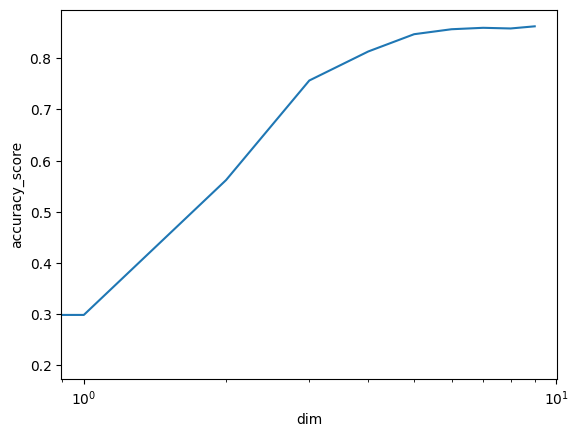

In [39]:
plt.xscale("log")
plt.plot(points)
plt.xlabel("dim")
plt.ylabel("accuracy_score")
plt.show()

Да, получилось выйти на плато в некотором смысле

In [5]:
points_svm = []
for dim in [1, 10, 50, 100, 200]: 
    print(int(dim))
    new_dim_model = RFFPipeline(classifier='svm', n_features=int(dim)).fit(x_train[ind_sub], y_train[ind_sub])
    y_test_pred = new_dim_model.predict(x_test)
    points_svm.append(accuracy_score(y_test, y_test_pred))

1
10
50
100
200


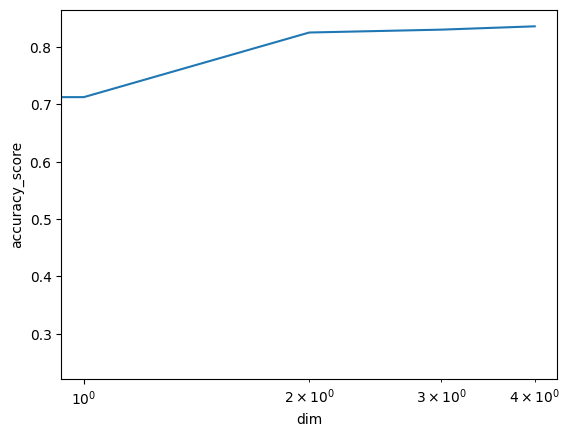

In [7]:
plt.xscale("log")
plt.plot(points_svm)
plt.xlabel("dim")
plt.ylabel("accuracy_score")
plt.show()

log reg быстрее и качество лучше. Хотя svm быстрее приходит к хорошему accuracy

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪